In [ ]:
//@version=5
indicator("Volume Profile and Indicator by Sunstoic", "v5 Vison Market Profile", overlay = true, max_boxes_count = 500, max_lines_count = 500, max_bars_back = 5000)


// Inputs
disp = display.all - display.status_line

vpGR = 'Volume & Sentiment Profile'

vpTP   = 'displays total trading activity (both buying and selling trading activity) over a specified time period at specific price levels\n\n' +
          'row lengths, indicates the amount of the traded activity at specific price levels\n\n' +
          ' - high traded zones - usually represents consolidation zones (value areas)\n' +
          ' - low traded zones - usually represents supply & demand or liquidity zones'
 
vpSH = input.bool(true, 'Volume Profile', group = vpGR, tooltip = vpTP)

vpUC = input.color(color.new(#000000, 50), '  Up Volume ', inline = 'VP', group = vpGR)
vpDC = input.color(color.new(#000000, 50), 'Down Volume ', inline = 'VP', group = vpGR)

vaUC = input.color(color.new(#000000, 50), '  Value Area Up', inline = 'VA', group = vpGR)
vaDC = input.color(color.new(#000000, 50), 'Value Area Down', inline = 'VA', group = vpGR)


// User Inputs
pcSH = input.string('Developing POC', 'Point of Control', options = ['Developing POC', 'Last (Line)', 'None'], inline = 'POC', group = vpGR, display = disp)
pocC = input.color(color.rgb(0, 0, 0), '', inline = 'POC', group = vpGR)
pocW = input.int(2, '', minval = 1, inline = 'POC', group = vpGR, display = disp)

// Mock Developing POC (replace with your own logic)
var float developingPOC = na
developingPOC := (high + low / 2)  // For demo purposes, this just uses the close

// Plot the POC using stepline if enabled
plot(pcSH == 'Developing POC' ? developingPOC : na,title = 'Developing POC', color = pocC,linewidth = pocW,style = plot.style_stepline)

vpVA = input.float(68, 'Value Area (%)', minval = 0, maxval = 100, group = vpGR, display = disp) / 100

vahS = input.bool(true, 'Value Area High (VAH)', inline = 'VAH', group = vpGR)
vahC = input.color(#2962ff, '', inline = 'VAH', group = vpGR)
vahW = input.int(1, '', minval = 1, inline = 'VAH', group = vpGR, display = disp)

vlSH = input.bool(true, 'Value Area Low (VAL)', inline = 'VAL', group = vpGR)
valC = input.color(#2962ff, '', inline = 'VAL', group = vpGR)
valW = input.int(1, '', minval = 1, inline = 'VAL', group = vpGR, display = disp)

spPT = 'polarity methods is a measure used to divide the total volume into either up volume (trades that moved the price up) or ' + 
         'down volume (trades that moved the price down), simply said conditions used to calculate up/down volume\n\n' +
         '* bar polarity\n   up     => if close > open\n   down => if close <= open\n\n' +
         '* bar buying/selling pressure\n   up     => if (close - low) > (high - close)\n   down => if (close - low) <= (high - close)'
spP1 = 'Bar Polarity'
spP2 = 'Bar Buying/Selling Pressure'
vpPT = input.string(spP1, 'Profile Polarity Method', options = [spP1, spP2], group = vpGR, tooltip = spPT, display = disp)
vsPT = vpPT == spP1

vpLR = input.string('Visible Range', 'Profile Lookback Range', options = ['Fixed Range', 'Visible Range'], group = vpGR, display = disp)
vpRL = vpLR == 'Visible Range'
vpLT = 'applicable when \'Lookback Range\' is selected as \'Fixed Range\''
vpLN = input.int(360, 'Lookback Length / Fixed Range', minval = 10, maxval = 5000, step = 10, group = vpGR, tooltip = vpLT, display = disp)
vpLN:= last_bar_index < vpLN ? last_bar_index : vpLN - 1

vpST = input.bool(true, 'Profile Stats', inline = 'STT', group = vpGR, display = disp)
ppLS = input.string('Small', "", options = ['Tiny', 'Small', 'Normal'], inline = 'STT', group = vpGR, display = disp)
lcDB = input.string('Top Right', '', options = ['Top Right', 'Middle Right', 'Bottom Left'], inline = 'STT', group = vpGR, display = disp)

vpLV = input.bool(true, 'Profile Price Levels', inline = 'BBe', group = vpGR)
rpLS = input.string('Small', "", options=['Tiny', 'Small', 'Normal'], inline = 'BBe', group = vpGR, display = disp)

vpPL = input.string('Right', 'Profile Placement', options = ['Right', 'Left'], group = vpGR, display = disp)
vpRT = vpPL == 'Right' 
vpNR = input.int(250, 'Profile Number of Rows' , minval = 10, maxval = 500 , step = 10, group = vpGR, display = disp)
vpWD = input.float(31, 'Profile Width', minval = 0, maxval = 250, group = vpGR, display = disp) / 100
vpHO = input.int(0, 'Profile Horizontal Offset', maxval = 50, group = vpGR, display = disp)

vaBG = input.bool(false, 'Value Area Background  ', inline = 'vBG', group = vpGR)
vBGC = input.color(color.new(#2962ff, 89), '', inline = 'vBG', group = vpGR)

vpBG = input.bool(false, 'Profile Range Background ', inline = 'pBG', group = vpGR)
bgC  = input.color(color.new(#2962ff, 95), '', inline = 'pBG', group = vpGR)


cbGR = 'Volume Weighted Colored Bars'

cbTT = 'Colors bars based on the bar\'s volume relative to volume moving average\n' +
         ' - Bold bars when bar\'s volume is above volume moving average * upper threshold\n' +
         ' - Light bars when bar\'s volume is below volume moving average * lower threshold'

vwcb = input.bool(false, 'Volume Weighted Colored Bars', group = cbGR, tooltip = cbTT)
upTH = input.float(1.618, '  Upper Threshold', minval=1., step=.1, group = cbGR, display = disp)
dnTH = input.float(0.618, '  Lower Threshold', minval=.1, step=.1, group = cbGR, display = disp) 


// User Defined Types
type bar
    float o = open
    float h = high
    float l = low
    float c = close
    float v = volume
    int   i = bar_index

type barData
    float [] bh
    float [] bl
    float [] bv
    bool  [] bp
    int   [] bn

type volData
    float [] vt
    float [] vb
    float [] vd

type tVP
    box         []  vp
    chart.point []  pPC
    polyline        dPC
    int             pcL
    int             laP
    int             lbP
    int             sI

type tVH
    line        []  vh
    chart.point []  pMA
    polyline        vMA


// Variables
var barData bD = barData.new(
     array.new <float> (na), 
     array.new <float> (na), 
     array.new <float> (na), 
     array.new <bool>  (na), 
     array.new <int>   (na)
 )

volData vD = volData.new(
     array.new <float> (vpNR, 0.), 
     array.new <float> (vpNR, 0.), 
     array.new <float> (vpNR, 0.)
 )

var tVP VP = tVP.new(
     array.new<box>         (na),
     array.new<chart.point> (na),
     polyline.new           (na), na, na, na, na
 )

var tVH VH = tVH.new(
     array.new<line>        (na),
     array.new<chart.point> (na),
     polyline.new           (na)
 )

bar b = bar.new()
bar [] ltfBD = array.new<bar> (1, bar.new())

var float pHST = na
var float pLST = na
var string ltf = na


// Functions / Methods
f_drawLineX(_x1, _y1, _x2, _y2, _xloc, _extend, _color, _style, _width) =>
    var id = line.new(_x1, _y1, _x2, _y2, _xloc, _extend, _color, _style, _width)
    line.set_xy1(id, _x1, _y1)
    line.set_xy2(id, _x2, _y2)
    line.set_color(id, _color)

f_drawLabelX(_x, _y, _text, _color, _style, _textcolor, _size, _tooltip) =>
    var lb = label.new(_x, _y, _text, xloc.bar_index, yloc.price, _color, _style, _textcolor, _size, text.align_left, _tooltip)
    lb.set_xy(_x, _y)
    lb.set_text(_text)
    lb.set_tooltip(_tooltip)
    lb.set_textcolor(_textcolor)

getData(_ltf) => request.security_lower_tf(syminfo.tickerid, _ltf, bar.new(), ignore_invalid_timeframe = true)

f_gTF(_d) => 
    int tfInMs = timeframe.in_seconds(timeframe.period)
    int  mInMS = 60

    if _d == 2
        switch
            tfInMs <                 30  =>  '1S'
            tfInMs <          1 * mInMS  =>  '5S'

            tfInMs <=        15 * mInMS  =>   '1'
            tfInMs <=        60 * mInMS  =>   '5'
            tfInMs <=       240 * mInMS  =>  '15'
            tfInMs <=      1440 * mInMS  =>  '60'
            => 'D'

    else if _d == 1
        switch
            tfInMs <                 15  =>  '1S'
            tfInMs <                 30  =>  '5S'
            tfInMs <          1 * mInMS  => '15S'

            tfInMs <=         5 * mInMS  =>   '1'
            tfInMs <=        15 * mInMS  =>   '5'
            tfInMs <=        60 * mInMS  =>  '15'
            tfInMs <=       240 * mInMS  =>  '60'
            tfInMs <=      1440 * mInMS  => '240'
            => 'D'

f_gTS(_t) =>
    switch _t
        'Tiny'   => size.tiny
        'Small'  => size.small 
        'Normal' => size.normal
        => size.auto

f_crossingLevelX(_price, _level) =>
    (_level > _price and _level < _price[1]) or (_level < _price and _level > _price[1])

alarm(_message) => 
    alert(syminfo.ticker + ' ' + _message + ', price ' + str.tostring(b.c, format.mintick) + ', timeframe ' + timeframe.period, alert.freq_once_per_bar)


// Calculations Volume Profile
nzV  = nz(b.v)

rpS  = f_gTS(rpLS)
ppLS:= f_gTS(ppLS)

tPOS = lcDB == 'Top Right' ? position.top_right
     : lcDB == 'Middle Right' ? position.middle_right 
     : position.bottom_left

if time == chart.left_visible_bar_time
    VP.sI := b.i

if vpRL
    vpLN := last_bar_index - VP.sI

if b.i == last_bar_index - vpLN
    VP.sI   := b.i
    pLST := b.l 
    pHST := b.h
else if b.i > last_bar_index - vpLN
    pLST := math.min(b.l, pLST)
    pHST := math.max(b.h, pHST)

if vpLN <= 200
    ltf := f_gTF(2)
    ltfBD := getData(f_gTF(2))  
else if vpLN <= 700
    ltf := f_gTF(1)
    ltfBD := getData(f_gTF(1)) 
else
    ltf := 'Chart'
    ltfBD := array.new<bar> (1, bar.new(b.o, b.h, b.l, b.c, b.v))

if barstate.ishistory and (b.i >= last_bar_index - vpLN) and b.i < last_bar_index and ltfBD.size() > 0

    if ltfBD.size() > 0 and not na(nz(ltfBD.get(0).v))
        for i = 0 to ltfBD.size() - 1
            bD.bh.push(ltfBD.get(i).h)
            bD.bl.push(ltfBD.get(i).l)
            bD.bv.push(ltfBD.get(i).v)

            if vsPT
                bD.bp.push(ltfBD.get(i).c > ltfBD.get(i).o)
            else
                bD.bp.push(ltfBD.get(i).c - ltfBD.get(i).l > ltfBD.get(i).h - ltfBD.get(i).c)

        bD.bn.push(ltfBD.size())

pSTP = (pHST - pLST) / vpNR

if barstate.islast and ltfBD.size() > 0

    if VP.vp.size() > 0
        for i = 0 to VP.vp.size() - 1
            box.delete(VP.vp.shift())

    if bD.bn.size() > vpLN
        qt = bD.bn.shift()
        for i = 0 to qt - 1
            bD.bh.shift()
            bD.bl.shift()
            bD.bv.shift()
            bD.bp.shift()

    VP.pPC.clear()
    VP.dPC.delete()

    if ltfBD.size() > 0 and not na(nz(ltfBD.get(0).v))
        for i = 0 to ltfBD.size() - 1
            bD.bh.push(ltfBD.get(i).h)
            bD.bl.push(ltfBD.get(i).l)
            bD.bv.push(ltfBD.get(i).v)

            if vsPT
                bD.bp.push(ltfBD.get(i).c > ltfBD.get(i).o)
            else
                bD.bp.push(ltfBD.get(i).c - ltfBD.get(i).l > ltfBD.get(i).h - ltfBD.get(i).c)

        bD.bn.push(ltfBD.size())

    bI  = vpLN
    bSZ = 0
    aSZ = bD.bv.size()

    for aI = 0 to aSZ - 1

        i = 0
        for pLL = pLST to pHST - pSTP by pSTP

            lH = bD.bh.get(aI)
            lL = bD.bl.get(aI)
            lV = bD.bv.get(aI)

            if lH >= pLL and lL < pLL + pSTP

                vPOR = if lL >= pLL and lH > pLL + pSTP
                    (pLL + pSTP - lL) / (lH - lL)
                else if lH <= pLL + pSTP and lL < pLL
                    (lH - pLL) / (lH - lL)
                else if lL >= pLL and lH <= pLL + pSTP
                    1
                else
                    pSTP / (lH - lL)

                vD.vt.set(i, vD.vt.get(i) + lV * vPOR)

                if bD.bp.get(aI)
                    vD.vb.set(i, vD.vb.get(i) + lV * vPOR)
            i += 1

        if pcSH == 'Developing POC'
            if aI == bD.bn.get(vpLN - bI)
                VP.pPC.push(chart.point.from_index(b.i[bI], math.avg(b.h[bI], b.l[bI])))
                VP.pPC.push(chart.point.from_index(b.i[bI] + 1, pLST + (vD.vt.indexof(vD.vt.max()) + .5) * pSTP))
                bSZ += bD.bn.get(vpLN - bI)
                bI  -= 1
            else if aI == (bSZ + bD.bn.get(vpLN - bI)) and bSZ != 0
                VP.pPC.push(chart.point.from_index(b.i[bI] + 1, pLST + (vD.vt.indexof(vD.vt.max()) + .5) * pSTP))
                bSZ += bD.bn.get(vpLN - bI)
                bI  -= 1
            else if bI == 0
                VP.pPC.push(chart.point.from_index(b.i[bI] + 1, pLST + (vD.vt.indexof(vD.vt.max()) + .5) * pSTP))
                bSZ += bD.bn.get(vpLN - bI)

    VP.dPC := polyline.new(VP.pPC, false, false, xloc.bar_index, pocC, color(na), line.style_solid, pocW)

    for i = 0 to vpNR - 1
        bbp = 2 * vD.vb.get(i) - vD.vt.get(i)
        vD.vd.set(i, vD.vd.get(i) + bbp * (bbp > 0 ? 1 : -1) )

    VP.pcL := vD.vt.indexof(vD.vt.max())
    ttV     = vD.vt.sum() * vpVA
    va      = vD.vt.get(VP.pcL)
    VP.laP := VP.pcL
    VP.lbP := VP.pcL
    
    while va < ttV
        if VP.lbP == 0 and VP.laP == vpNR - 1
            break

        vaP = 0.
        if VP.laP < vpNR - 1 
            vaP := vD.vt.get(VP.laP + 1)

        vbP = 0.
        if VP.lbP > 0
            vbP := vD.vt.get(VP.lbP - 1)
        
        if vaP >= vbP
            va  += vaP
            VP.laP += 1
        else
            va  += vbP
            VP.lbP -= 1

    vaH = pLST + (VP.laP + 1.) * pSTP
    poc = pLST + (VP.pcL + .5) * pSTP
    vaL = pLST + (VP.lbP + .0) * pSTP
    pLN = vpLN > 360 ? 360 : vpLN

    
    if pcSH == 'Last (Line)'
        f_drawLineX(VP.sI, poc, last_bar_index, poc, xloc.bar_index, extend.none, pocC, line.style_solid, pocW)

    
    if vaBG
        VP.vp.push(box.new(VP.sI, vaL, last_bar_index, vaH, vBGC, 1, line.style_dotted, bgcolor = vBGC))

    
    for i = 0 to vpNR - 1
    
        if vpSH
            sBI = vpRT ? int((pLN * vpWD + vpHO)) + int(last_bar_index - vD.vb.get(i) / vD.vt.max() * pLN * vpWD) : VP.sI
            eBI = vpRT ? int((pLN * vpWD + vpHO)) + last_bar_index : int(sBI + vD.vb.get(i) / vD.vt.max() * pLN * vpWD)
            VP.vp.push(box.new(sBI, pLST + (i + .1) * pSTP, eBI, pLST + (i + .9) * pSTP, color(na), bgcolor = i >= VP.lbP and i <= VP.laP ? vaUC : vpUC))

            sBI := vpRT ? sBI : eBI
            eBI := vpRT ? sBI - int( (vD.vt.get(i) - vD.vb.get(i)) / vD.vt.max() * pLN * vpWD) : sBI + int( (vD.vt.get(i) - vD.vb.get(i)) / vD.vt.max() * pLN * vpWD)
            VP.vp.push(box.new(sBI, pLST + (i + .1) * pSTP, eBI, pLST + (i + .9) * pSTP, color(na), bgcolor = i >= VP.lbP and i <= VP.laP ? vaDC : vpDC))


// Calculations Volume Histogram
pHSTv = ta.highest(b.h, vpLN < 497 ? vpLN : 496)
pLSTv = ta.lowest (b.l, vpLN < 497 ? vpLN : 496)
vHST  = ta.highest(nzV, vpLN < 497 ? vpLN : 496)





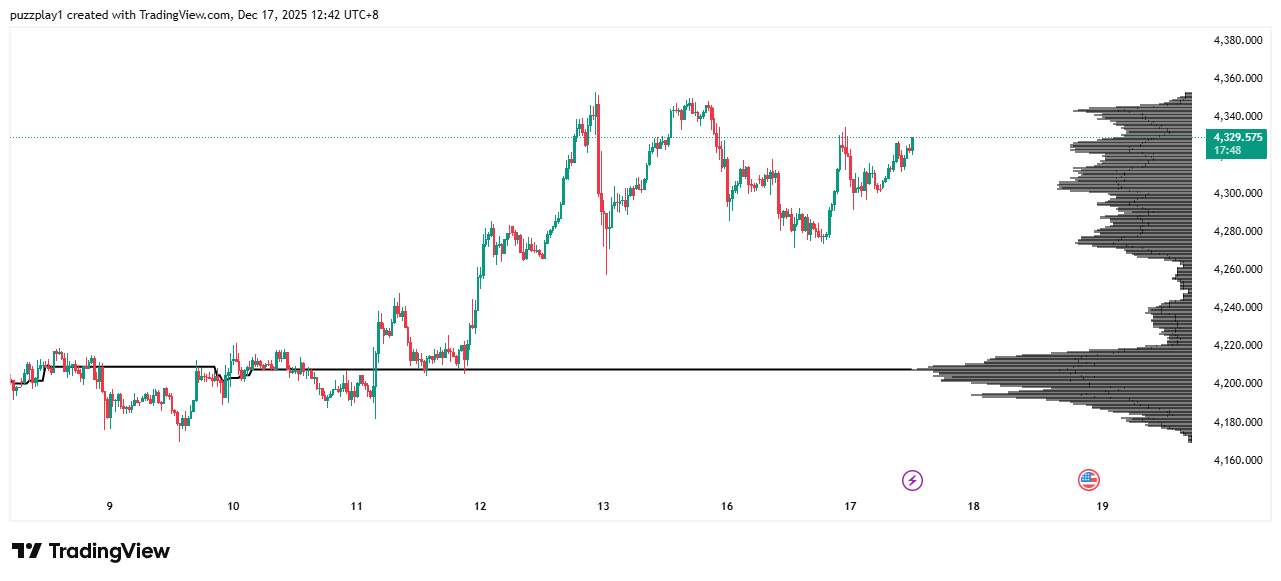